In [5]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.problems import grover_problem_oracle

In [20]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# Turning the Problem into a Circuit

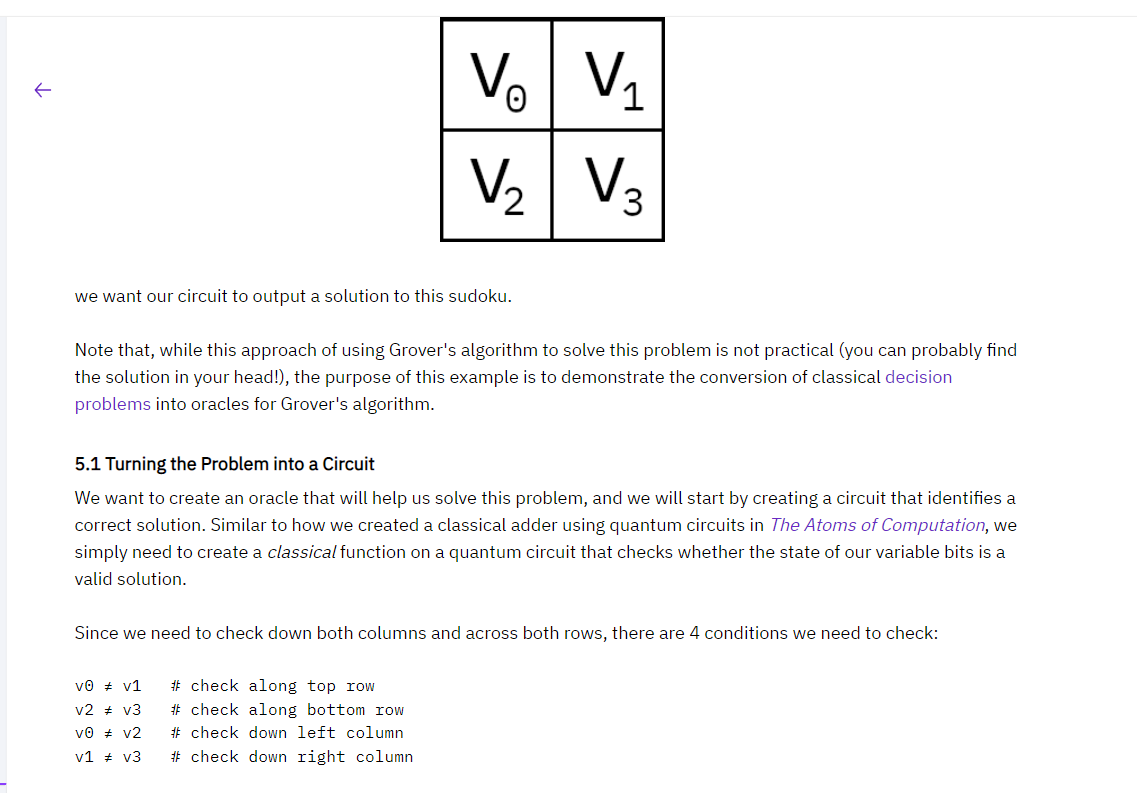

In [6]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [14]:
#To check these clauses computationally, we will use the XOR gate (we came across this in the atoms of computation)
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the output0 bit in the circuit below will only be flipped if input0 ≠ input1:

In [15]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
            │       
 input_1: ──┼────■──
          ┌─┴─┐┌─┴─┐
output_0: ┤ X ├┤ X ├
          └───┘└───┘

This circuit checks whether input0 == input1 and stores the output to output0. To check each clause, we repeat this circuit for each pairing in clause_list and store the output to a new bit

In [16]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

The final state of the bits c0, c1, c2, c3 will only all be 1 in the case that the assignments of v0, v1, v2, v3 are a solution to the sudoku. To complete our checking circuit, we want a single bit to be 1 if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

In [17]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

The circuit above takes as input an initial assignment of the bits v0, v1, v2 and v3, and all other bits should be initialized to 0. After running the circuit, the state of the out0 bit tells us if this assignment is a solution or not; out0 = 0 means the assignment is not a solution, and out0 = 1 means the assignment is a solution.

# Uncomputing, and Completing the Oracle

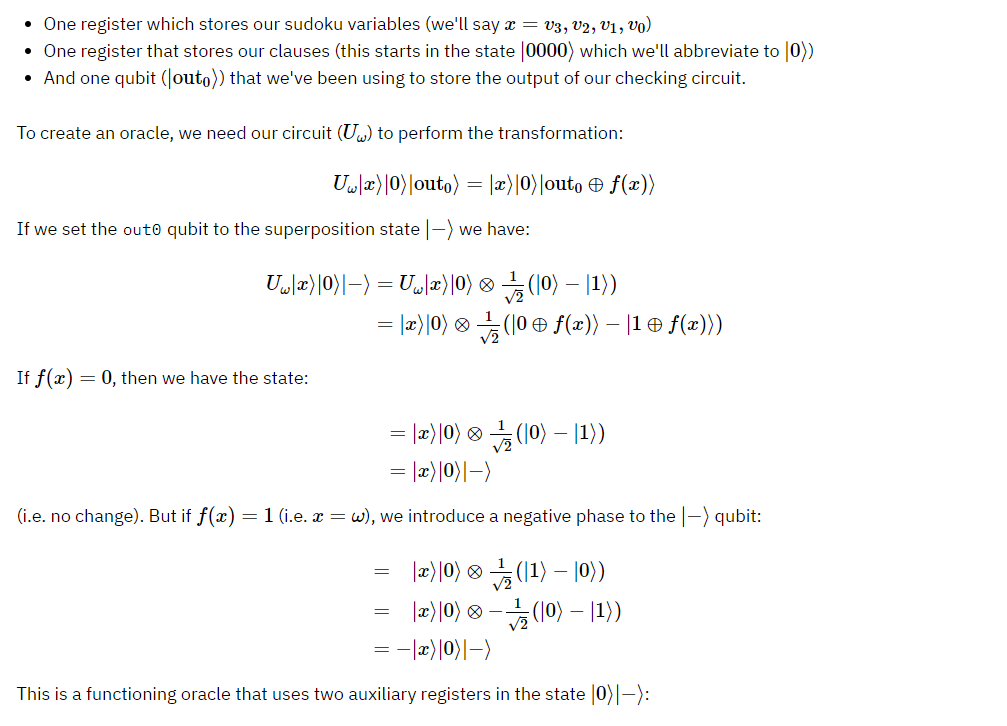

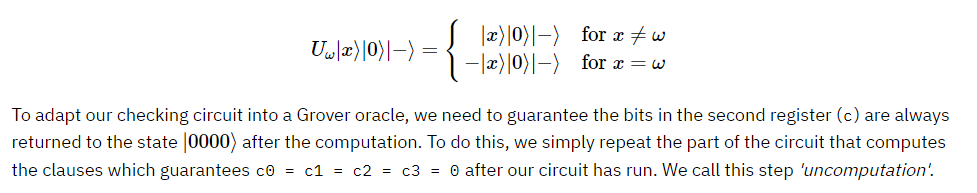

In [18]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
  out_0: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«  out_0: ───────────────
«                        
«cbits: 4/═══════════════
«

# The full Algorithm

In [21]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

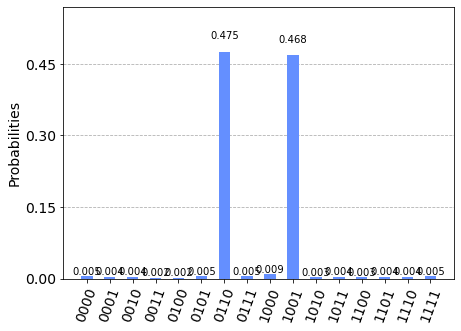

In [23]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

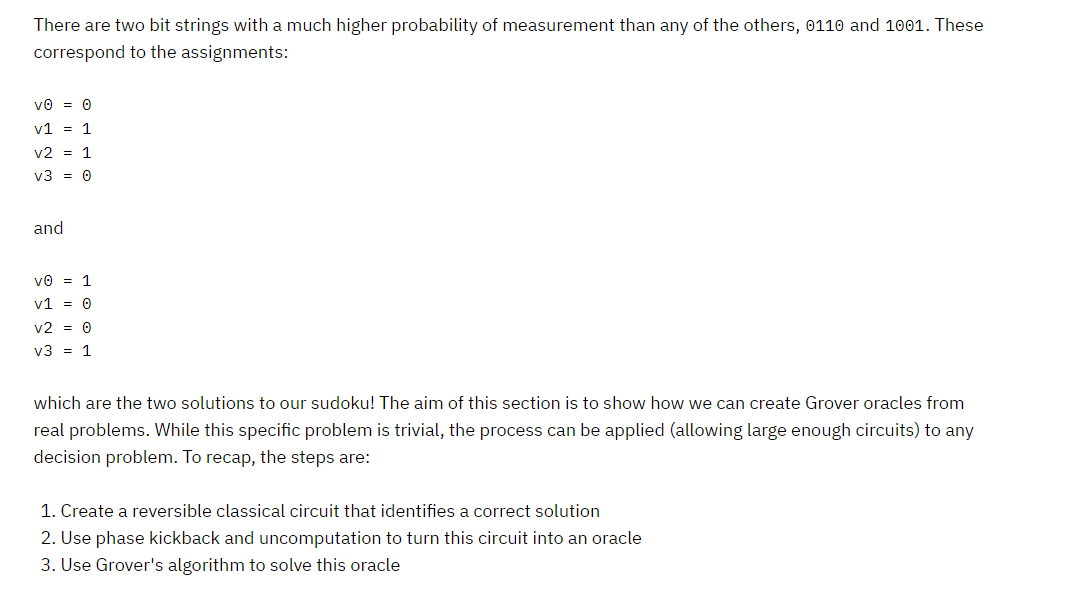